# Chapter 7 - Eligibility Traces

This chapter starts by introducing n-step TD methods, which sit between the two extremes: TD(0), or 1-step TD and Monte-Carlo (which can be considered an $\infty$-step TD). Then it builds on that to consider n-step backups and n-step returns, and mixing multiple n-step returns into a complex backup (i.e. weighted average of multiple n-step returns).

It then looks at the TD($\lambda$) family of algorithms from two perspectives - forward and backward view, by using forward for a better conceptual understanding but awkward to compute, while the backward view is more appropriate for the actual implementation by making use of eligibility traces.

And finally we are introduced to some variants of known algorithms that use the TD($\lambda$) updates, like Sarsa($\lambda$), Q($\lambda$), etc.

### Exercise 7.1

Why do you think a larger random walk task (19 states instead of 5) was used in the examples of this chapter? Would a smaller walk have shifted the advantage to a different value of $n$? How about the change in left-side outcome from $0$ to $-1$? Would that have made any difference in the best value of $n$?

A random walk over a small number of states should see not much difference between using 1-step TD updates or using every-visit MC, because the probability of reaching a terminal state from any given state is relatively high, e.g. between $\frac{1}{2}$ and $\frac{1}{8}$ for the 5 states task. That means that a small proportion of epsisodes would actually use a full n-step backup for the updates, i.e. after some (small) optimal length $n^*$, the value of longer $n$ would bring no benefit. Therefore a random walk task with 19 states gives more "opportunity" to show how different outcomes can be for different $n$'s, and how the optimum is somewhere in the middle between 1-step TD and MC.

For a similar reason, the change of the left terminal reward to $-1$ provides a more "dramatic" curve between multiple values of $n$; intuitively I expect the curves would have been flatter if the left terminal reward remained $0$, especially over only 10 episodes to learn from.

### Exercise 7.2

Why do you think on-line methods worked better than off-line methods on the example taks?

I expect the off-line methods have a slower start on most tasks, because they only update once per episode. In this case the results presented and the graphs in Figure 7.2 used only the first 10 episodes, which can be considered little for a task with 19 states! However, it must be mentioned that the advantage of off-line methods is that the update is usually more stable, being an average over potentially multiple passes through a state per episode and on the longer term converge to the same optimum as the on-line methods.

### Exercise 7.3

Explain why the plots for off-line n-step TD show a worse performance for $n=3, 5, 7, 9$ at a much lower value of $\alpha$ than for $n=2, 4, 6, etc.$ (Figure 7.2)

First read the [Other Notes on the Errata page](http://incompleteideas.net/book/first/errata.html). <br>

Initially my intuition went something like this. In this task all rewards are $0$ except for the terminal transitions. So for all n-step returns starting from some $s_{start}$, the off-line update only depends on the values of all the end state(s) reached after $n$ jumps (or less if a terminal state is reached). Let's call them $s_{end}$.

The first observation is that by starting from any fixed position $s_{start}$ and making n-step jumps, __if $n$ is odd, the end positions will always have the opposite parity of the starting position__ (excepting terminal states when the walk is cut short). For example from state $7$, all possible 3-step jumps finish in either $4$, $6$, $8$ or $10$. But __if $n$ is even, the end state always has the same parity as the starting state__ (including itself). For instance from $7$ all possible 4-step jumps finish in either $3$, $5$, $7$, $9$ or $11$.

The second observation, according to __the formula on page 166 for off-line updates__, says that all increments are accumulated "on the side" during the episode and applied at the end. Notice that in our case each increment at time $t$ is something like this, since $\gamma=1$ and all intermediary rewards are $0$ as discussed above: 

$$
\Delta V_t(s_{start}) = \alpha \left[ R_t^{(n)} - V_t(s_{start}) \right] = \alpha \left[ V_t(s_{end}) - V_t(s_{start}) \right], \\
\text {if } s_t = s_{start} \text { and } 0 \text { otherwise}.
$$

The off-line update thus becomes, for each $s_{start}$ visited during the episode:

$$
V(s_{start}) \leftarrow V(s_{start}) + \alpha \sum_{t=0}^{T-1} \Delta V_t(s_{start}) = V(s_{start}) + \alpha \sum_{s_{end}} \left[ V(s_{end}) - V(s_{start}) \right]
$$


From these two observations we derive two consequences:

 - __If $n$ is odd__, after every off-line update as per the formula above, the values of $V(odd\_positions)$ will be updated towards some function of $V(even\_positions)$ and vice-versa. Which can create a self-reinforcing error propagation from one update to the next over multiple episodes, especially for the positions far from the two terminal states. This effect is magnified by a large $\alpha$.
 
 - __If $n$ is even__, a significant proportion of n-step walks will finish in the starting position, thus reducing the update value, because the n-step TD error will be zero for those cases (as per the formula). It could be considered equivalent to using a smaller $\alpha$ overall. Also, $V(odd\_positions)$ will always be updated only from other $V(odd\_positions)$ and similarly for even positions. This kind of "segregation of states" means that if there is a large over/under-estimate somewhere, it will get propagated to at most half of the states around it, not to all.

For these two reasons we could expect a worse performance from odd $n$'s, especially for larger values of $\alpha$ and small number of episodes.

__But this explanation doesn't account for something much more curious and obvious, in retrospect. If you look closely at both graphs in Figure 7.2, the x-axis are very different!__ For the on-line update, $\alpha$ sweeps from $0$ to $1$, while in the off-line update it stops at $0.3$. As we'll see in the plots below, if $\alpha$ was made larger than $0.3$, the off-line RMS error shoots up to huge numbers, for both odd and even $n$'s. So let's implement a quick off-line n-step TD algorithm, over 100 experiments of 10 random walks starting from the middle, i.e. the same settings as in the book.

In [112]:
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Implementing the 19 states random walk task
# rewards are -1 and 1 for transitions to the left 
# and right terminals and 0 everywhere else.
def generate_walk(nb_states=19):
    s = nb_states // 2 + 1  # start from the center state
    walk = [s]
    while s > 0 and s <= nb_states:
        move = random.choice([-1, 1])
        s += move
        walk.append(s)
    return walk

# Create a batch of 100 experiments
# of 10 random walks each.
experiments = []
for e in range(100):
    # Generate 10 different walks
    walks = []
    for _ in range(10):
        walks.append(generate_walk(nb_states=19))
    experiments.append(walks)

In [108]:
# Implement the off-line n-step TD update
# from a list of walks
def off_line_n_step_update(walks, n, alpha, nb_states=19):
    # init V=0, plus -1, 1 on the sides
    V = [-1.] + [0.] * nb_states + [1.]
    for walk in walks:
        # DeltaV to be used for the update at the end of the episode
        DV = {}
        DV_k = {}  # counter

        for pos in range(len(walk)-1):
            start_state = walk[pos]
            end_state = walk[min(pos + n, len(walk)-1)]

            if start_state not in DV:
                DV[start_state] = 0.
                DV_k[start_state] = 0
            # accumulate DeltaV "on the side"
            DV[start_state] += V[end_state] - V[start_state]
            DV_k[start_state] += 1

        new_V = V.copy()
        # update V for all visited states
        for s in range(1, nb_states+1):
            if s in DV:
                # original formula page 166
                new_V[s] = new_V[s] + alpha * DV[s]
        V = new_V
    return V

In [72]:
# The true value of each state in the 19 states random walk
true_V = [(k-10.)/10. for k in range(21)]

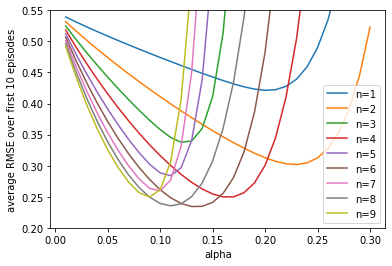

In [115]:
# Reproduce Figure 7.2, off-line update
alpha_list = [a/100. for a in range(1, 31)] # just from 0.01 to 0.3
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.ylim(bottom=0.2, top=0.55)
plt.legend()
plt.show()

It's visible how the RMS errors get clustered and shooting up for $n=3, 5, 7, 9$ around $\alpha=0.15$, much earlier than for $n=1, 2, 4, 6, 8$. This confirms the behaviour described in Exercise 7.3.
But see how they tend to shoot out of the plot almost vertically. What if we don't cut it at RMSE = 0.55?

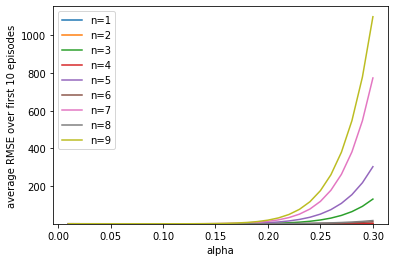

In [116]:
# Reproduce Figure 7.2, off-line update, but no upward limit
alpha_list = [a/100. for a in range(1, 31)] # just from 0.01 to 0.3
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.ylim(bottom=0.2)
plt.legend()
plt.show()

Ok, so the RMS errors get huge for odd $n$'s when $\alpha$ approaches $0.3$. How can this be? 

Even if the estimates were really wrong, for instance the extremes of $1$ vs. $-1$, one wouldn't expect RMSE to go beyond $\sqrt{(1-(-1))^2} = 2$. So what is going on?

What if we plot only the RMSE for even $n$'s; are they behaving better?

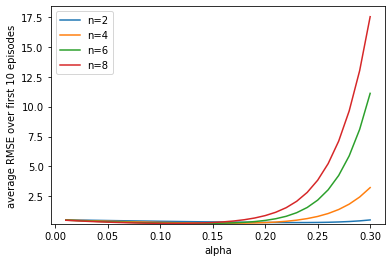

In [117]:
# Reproduce Figure 7.2, off-line update, but only for even n's and no upward limit
alpha_list = [a/100. for a in range(1, 31)] # just from 0.01 to 0.3
for n in [2, 4, 6, 8]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.ylim(bottom=0.2)
plt.legend()
plt.show()

Hmmm, so they're also misbehaving, but were eclipsed by the much larger RMS errors for odd $n$'s.

Even more, if we allow $\alpha$ to go all the way to $1$ as for the on-line update graph, we get way worse performance:

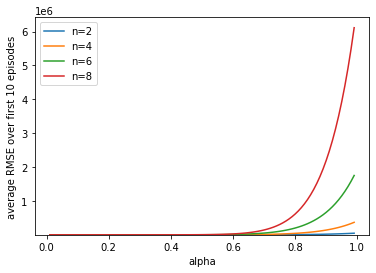

In [118]:
# Reproduce Figure 7.2, off-line update, but only for even n's and no upward limit
alpha_list = [a/100. for a in range(1, 100)] # from 0.01 to 0.99
for n in [2, 4, 6, 8]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.ylim(bottom=0.2)
plt.legend()
plt.show()

So for $\alpha$ > 0.5, RMSE quickly goes into the millions.

By now we're confident that the problem is much worse (and different) than initially thought, __regardless of $n$ being even or odd. It might indicate a problem in the algorithm. And indeed that's what is happening.__ If we go back to page 166, it says that "the increments are accumulated on the side" and applied at the end of the episode, which sounds right. The formula next to it is also given. But at a closer inspection, suppose you begin with $V(s) = 0$ for some state $s$ and we take 10 n-step walks from it, of which 8 finish in the left terminal and 2 in the right terminal. So the accumulated TD error is $\sum \Delta V(s) = \alpha \left[ 8 (-1 - 0) + 2 (1 - 0) \right] = 6 \alpha$. At the end of the episode we apply the update and $V(s)$ becomes $V(s) + 6 \alpha$. But if $\alpha$ is large enough, in this case any value above $\frac{1}{6} \approx 0.17$, then $V(s) \gt 1$, i.e. outside any reasonable expectation that $-1 \le V(s) \le 1$. Once the estimates escape the interval $[-1, 1]$, the self-reinforcing effect described above is taking over and the estimates get very wrong as we have seen, especially for larger $\alpha$.

What is the fix?

Well, rather simple actually, instead of adding the __sum__ of the accumulated increments $\Delta V(s)$ to $V(s)$, we add their __mean__. This guarantees the value estimates never go below / above the minimum / maximum target values, and RMSE now behave nicely for any $\alpha \in (0, 1)$.

In [120]:
# Implement the corrected off-line n-step TD update
# from a list of walks
def off_line_n_step_update(walks, n, alpha, nb_states=19):
    # init V=0, plus -1, 1 on the sides
    V = [-1.] + [0.] * nb_states + [1.]
    for walk in walks:
        # DeltaV to be used for the update at the end of the episode
        DV = {}
        DV_k = {}  # counter

        for pos in range(len(walk)-1):
            start_state = walk[pos]
            end_state = walk[min(pos + n, len(walk)-1)]

            if start_state not in DV:
                DV[start_state] = 0.
                DV_k[start_state] = 0
            # accumulate DeltaV "on the side"
            DV[start_state] += V[end_state] - V[start_state]
            DV_k[start_state] += 1

        new_V = V.copy()
        # update V for all visited states
        for s in range(1, nb_states+1):
            if s in DV:
                # original formula page 166
                # new_V[s] = new_V[s] + alpha * DV[s]
                # simply divide the increments by their count
                new_V[s] = new_V[s] + alpha * DV[s] / DV_k[s]
        V = new_V
    return V

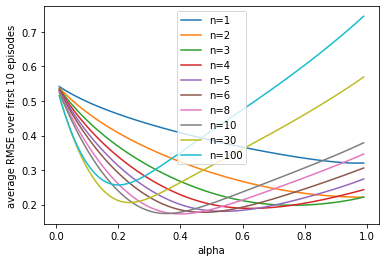

In [124]:
# off-line n-step TD update, this time with average update
alpha_list = [a/100. for a in range(1, 100)] # from 0.01 to 0.99
for n in [1, 2, 3, 4, 5, 6, 8, 10, 30, 100]:
    rmse = []
    for alpha in alpha_list:
        tmp_rmse = 0.
        for e in range(100):
            walks = experiments[e]  # the set of 10 walks
            V = off_line_n_step_update(walks, n=n, alpha=alpha)
            tmp_rmse += math.sqrt(sum([(vi - true_vi)**2 for vi, true_vi in zip(V, true_V)]) / (len(V) - 2)) # exclude terminal states
        rmse.append(tmp_rmse / 100.)  # average over the 100 experiments
    plt.plot(alpha_list, rmse, label=f'n={n}')
plt.xlabel('alpha')
plt.ylabel('average RMSE over first 10 episodes')
plt.legend()
plt.show()

All looks good now! No more odd vs. even $n$'s difference; they seem to form a nice regular pattern. And more importantly, no huge errors for larger $\alpha$. The results are similar (or slightly better) to on-line n-step TD. And actually that's what one would expect, more stable estimates from accumulating (and aggregating) multiple noisy signals.

### Exercise 7.4

(...) What is the equation relating the parameter $\lambda$ and the half-life ${\tau}_{\lambda}$, the time by which the weighting sequence will have fallen to half of its initial value?

The largest weight is for the 1-step return, i.e. $1 - \lambda$. In general, the weight for an n-step return is $(1 - \lambda) \lambda^{n-1}$. Now we require that for some time step $\tau_{\lambda}$, its corresponding weight is half of the initial value, i.e. 

$$
(1 - \lambda) \lambda^{\tau_{\lambda} - 1} = \dfrac{1}{2} (1 - \lambda) \iff \tau_{\lambda} - 1 = \dfrac {\ln \frac{1}{2}} {\ln \lambda} \iff \boxed { \tau_{\lambda} = 1 - \dfrac {\ln 2} {\ln \lambda} } \qquad \square
$$

### Exercise 7.5

Although TD($\lambda$) only approximates the $\lambda$-return algorithm when done on-line, perhaps there is a slightly different TD method that would maintain the equivalence even in the on-line case. One idea is to define the TD error instead as $\delta_t = r_{t+1} + \gamma V_t(s_{t+1}) - V_{t-1}(s_t)$ and the n-step return as $R_t^{(n)} = r_{t+1} + ... + \gamma^{n-1} r_{t+n} + \gamma^n V_{t+n-1} (s_{t+n})$. Show that in this case the modified TD($\lambda$) algorithm would then achieve exactly $\Delta V_t(s_t) = \alpha \left[ R_t^{\lambda} - V_{t-1}(s_t) \right]$, even in the case of on-line updating with large $\alpha$. In what ways might this modified TD($\lambda$) be better or worse than the conventional one described in the text? Describe an experiment to assess the relative merits of the two algorithms.

__Answer__: The problem of the on-line TD($\lambda$) is that $V$ changes at every step, so the equivalence with the $\lambda$-return algorithm can't be proved other than approximately (see the proof in Section 7.4). Let's use the new definitions from this exercise to attempt a similar proof.

We start by looking on the right side of equation (7.8). An individual update of the modified $\lambda$-return becomes:

$$
\begin{align*}
    \dfrac {1} {\alpha} DV_t^{\lambda} (s_t) & = R_t^{\lambda} - V_{t-1}(s_t) \\
    & = -V_{t-1}(s_t) && + ( 1 - \lambda) \lambda^0 [r_{t+1} + \gamma V_t(s_{t+1})] \\
    & && + ( 1 - \lambda) \lambda^1 [r_{t+1} + \gamma r_{t+2} + \gamma^2 V_{t+1}(s_{t+2})] \\
    & && + ( 1 - \lambda) \lambda^2 [r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \gamma^3 V_{t+2}(s_{t+3})] \\
    & && + \qquad \qquad \qquad \vdots \qquad \qquad \vdots \qquad \qquad \vdots \qquad \qquad \ddots \\
    & && \\
    & && \text {and after same reorganizing terms by column, as in Section 7.4}
    & && \\
    & = -V_{t-1}(s_t) \\
    & \quad && + (\gamma \lambda)^0 [r_{t+1} + \gamma V_t(s_{t+1}) - \gamma \lambda V_t(s_{t+1})] \\
    & \quad && + (\gamma \lambda)^1 [r_{t+2} + \gamma V_{t+1}(s_{t+2}) - \gamma \lambda V_{t+1}(s_{t+2})] \\
    & \quad && + (\gamma \lambda)^2 [r_{t+3} + \gamma V_{t+2}(s_{t+3}) - \gamma \lambda V_{t+2}(s_{t+3})] \\
    & && \qquad \vdots \\
    \\
    & = && \quad (\gamma \lambda)^0 [r_{t+1} + \gamma V_t(s_{t+1}) - V_{t-1}(s_{t})] \\
    & && + (\gamma \lambda)^1 [r_{t+2} + \gamma V_{t+1}(s_{t+2}) - V_{t}(s_{t+1})] \\
    & && + (\gamma \lambda)^2 [r_{t+3} + \gamma V_{t+2}(s_{t+3}) - V_{t+1}(s_{t+2})] \\
    & && \qquad \vdots \\
    \\
    & = \sum_{k=t}^{\infty} (\gamma \lambda)^{k-t} \delta_k \\
    & = \sum_{k=t}^{T-1} (\gamma \lambda)^{k-t} \delta_k \\
\end{align*}
$$

Note that this time the previous equality is __exact__, due to the modified definition of $\delta_t$ and the fact that $V$ doesn't need to remain fixed as before. For every term in the sum, we only need the current and previous values of $V$ at any time step.

The rest of the proof follows exactly the same as in Section 7.4, by noticing that:

$$
    \sum_{t=0}^{T-1} \Delta V_t^{\lambda} (s_t) \mathcal{I}_{ss_t} = \sum_{t=0}^{T-1} \alpha \mathcal{I}_{ss_t} \sum_{k=t}^{T-1} (\gamma \lambda)^{k-t} \delta_k \text {, which is the same as (7.9)}
$$

So this proves that the off-line $\lambda$-return algorithm with the redefined n-step return $R_t^{(n)}$ is exactly equivalent to the on-line TD($\lambda$) with the redefined increment $\delta_t$.

It's not immediately clear if this modified on-line TD($\lambda$) algorithm is better than the conventional one, because the increment is now relative to a previous estimation of $V(s_t)$, i.e. $V_{t-1}(s_t)$, not the latest available $V_t(s_t)$. An experiment could be run on the 19-states random walk task and compare RMS error from true values after some number of episodes. In particular by using a large value of $\alpha$, the difference should be clear at the same level of $\lambda$.

### Exercise 7.6

In Example 7.5, suppose from state $s$ the $wrong$ action is taken twice before the $right$ action is taken. If accumulated traces are used, then how big must the trace parameter $\lambda$ be in order for the $wrong$ action to end up with a larger eligibility trace than the $right$ action?

__Answer__: Assuming $e(s, \cdot) = 0$ initially for both actions, they change as follows after every step:

$$
\begin{align*}
& \text {action} && e(s, wrong) && e(s, right) \\
& wrong && 1 && 0 \\
& wrong && \gamma \lambda + 1 && 0 \\
& right && \gamma \lambda (\gamma \lambda + 1) && 1
\end{align*}
$$

So we must solve for $\lambda$ such that $(\gamma \lambda)^2 + \gamma \lambda > 1 \text {, where } \gamma, \lambda \in (0, 1]$.

So $\gamma \lambda > \dfrac {\sqrt{5} - 1} {2} \implies \boxed {\lambda > \dfrac {\sqrt{5} - 1} {2 \gamma} \approx \dfrac {0.62} {\gamma}}$.

### Exercise 7.7

Program Example 7.5 and compare accumulate-trace and replace-trace versions of Sarsa($\lambda$) on it, for $\lambda = 0.9$ and a range of $\alpha$ values. Can you empirically demonstrate the claimed advantage of replacing traces on this example?

In [154]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [207]:
# Very simple implementation of Q values
# as a dictionary.
class ActionValue:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.Q = dict()
        for s in range(1, 6):
            for a in ['right', 'wrong']:
                self.Q[(s, a)] = random.uniform(0, 1)
    
    def __call__(self, s, a=None):
        if a is None:
            p_greedy = random.uniform(0, 1)
            if self.Q[(s, 'right')] > self.Q[(s, 'wrong')]:
                if p_greedy < self.epsilon:
                    return 'wrong'
                else:
                    return 'right'
            elif self.Q[(s, 'right')] == self.Q[(s, 'wrong')]:
                if p_greedy < 0.5:
                    return 'wrong'
                else:
                    return 'right'
            else:
                if p_greedy < self.epsilon:
                    return 'right'
                else:
                    return 'wrong'
        else:
            return self.Q[(s, a)]
    
    def update(self, s, a, increment):
        self.Q[(s, a)] += increment

# Elibility traces implemented as a dictionary.
class EligibilityTraces:
    def __init__(self, gamma, lam):
        self.gamma = gamma
        self.lam = lam
        self.e = dict()
        for s in range(1, 6):
            for a in ['right', 'wrong']:
                self.e[(s, a)] = 0.
        
    def __call__(self, s, a):
        return self.e[(s, a)]
    
    def accumulate(self, s, a):
        self.e[(s, a)] += 1.
    
    def replace(self, s, a):
        self.e[(s, a)] = 1.
    
    def decay(self):
        for s in range(1, 6):
            for a in ['right', 'wrong']:
                self.e[(s, a)] *= self.gamma * self.lam


# Simple implementation of Sarsa(lambda) algorithm.
# Environment is very simple, transitions and rewards are
# deterministic, so many things are just hard-coded.
def play_episode(Q, alpha, gamma, lam, s=1, train=False, accumulate=True):
    e = EligibilityTraces(gamma=gamma, lam=lam)
    terminal = False
    R = 0.
    discount = 1.
    a = Q(s)  # an epsilon-greedy policy from Q
    while not terminal:
        # take action a
        if a == 'right':
            if s == 5:
                r = 1.
                terminal = True
            else:
                r = 0.
                next_s = s + 1
                next_a = Q(next_s)
        else:
            r = 0.
            next_s = s
            next_a = Q(next_s)
        R += discount * r
        discount *= gamma
    
        if train:
            next_Q_val = 0.
            if not terminal:
                next_Q_val = Q(next_s, next_a)
            delta = r + next_Q_val - Q(s, a)
            if accumulate:
                e.accumulate(s, a)
            else:
                e.replace(s, a)
            for s in range(1, 6):
                for a in ['right', 'wrong']:
                    Q.update(s, a, increment=alpha * delta * e(s, a))
            e.decay()
        
        if not terminal:
            s = next_s
            a = next_a
    return R

In [230]:
# Capture returns progress during first 100 episodes.
# Average across 100 random experiments for each alpha.
experiments = 100
episodes = 100
R_acc = dict()
R_repl = dict()

for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
    # accumulating traces
    R_acc[alpha] = [0] * episodes
    for experiment in range(experiments):
        Q_acc = ActionValue()  # a new policy (Q) for each experiment
        for episode in range(episodes):
            R = play_episode(Q_acc, alpha=0.1, gamma=0.99, lam=0.9, s=1, train=True, accumulate=True)
            R_acc[alpha][episode] += R / experiments

    # replacing traces
    R_repl[alpha] = [0] * episodes
    for experiment in range(experiments):
        Q_repl = ActionValue()  # a new policy (Q) for each experiment
        for episode in range(episodes):
            R = play_episode(Q_repl, alpha=0.1, gamma=0.99, lam=0.9, s=1, train=True, accumulate=False)
            R_repl[alpha][episode] += R / experiments

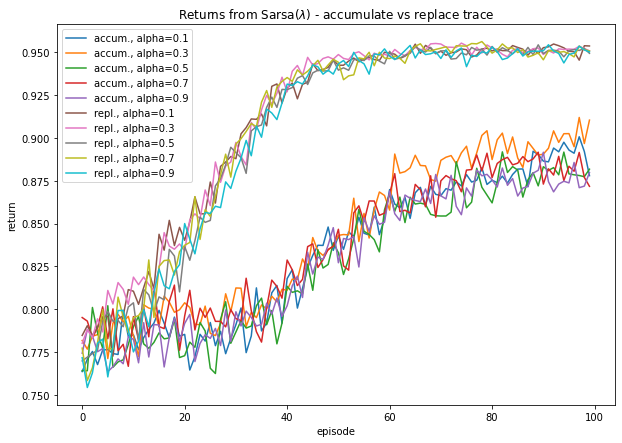

In [232]:
fig, ax = plt.subplots(figsize=(10, 7))
for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
    ax.plot(R_acc[alpha], label=f'accum., alpha={alpha}')
for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
    ax.plot(R_repl[alpha], label=f'repl., alpha={alpha}')
plt.xlabel('episode')
plt.ylabel('return')
plt.title('Returns from Sarsa($\lambda$) - accumulate vs replace trace')
plt.legend()
plt.show()

This proves empirically that replace-traces learn and achieve optimum policy (with Sarsa($\lambda$)) much faster than accumulate-traces, at all levels of $\alpha$.

### Exercise 7.8

Draw a backup diagram for Sarsa($\lambda$) with replacing traces.

In the case of replacing traces, the eligibility variable $e_t(s, a)$ works as usual, i.e. decays by $(\gamma \lambda)^k$ for each step $(t+k)_{k > 0}$, __for as long as__ $s_{t+k} \ne s$ and $a_{t+k} \ne a$. When $s_{t+k} = s$ and $a_{t+k} = a$ it simply becomes $1$ and breaks the recursive relationship with previous values.

In the forward view, this simply means that the backup only depends on the return over state-action pairs up until the first revisit of (s, a):

$$
\text {Sarsa} (\lambda) \text { with replacing traces} \\
\text {---------------------------------------------------------------------} \qquad \qquad \qquad \qquad \\
$$

$$
\begin{align*}
    & \, \bullet && \qquad\, \bullet && \qquad\, \bullet && \qquad\, \bullet && \qquad\, \bullet \longleftarrow (s, a) \\
    & \mid && \qquad \mid && \qquad \mid && \qquad \mid && \qquad \mid \\
    & \bigcirc && \qquad \bigcirc && \qquad \bigcirc && \qquad \bigcirc && \qquad \bigcirc \\
    & \mid && \qquad \mid && \qquad \mid && \qquad \mid && \qquad \mid \\
    & \, \bullet && \qquad\, \bullet && \qquad\, \bullet && \qquad\, \bullet && \qquad\, \bullet \\
    & 1-\lambda && \qquad \mid && \qquad \mid && \qquad \mid && \qquad \mid \\
    &  && \qquad \bigcirc && \qquad \bigcirc && \qquad \bigcirc && \qquad \bigcirc \\
    &  && \qquad \mid && \qquad \mid && \qquad \mid && \Large {\cdots} ~ \normalsize \mid \\
    &  && \qquad\, \bullet && \qquad\, \bullet && \qquad\, \bullet && \qquad\, \bullet \\
    &  && (1-\lambda) \lambda && \qquad \mid && \qquad \mid && \qquad \mid \\
    &  &&  && \qquad \bigcirc && \qquad \bigcirc && \qquad \bigcirc \\
    &  &&  && \qquad \bot && \qquad \bot && \qquad \bot \longleftarrow \text {cut returns here} \\
    &  &&  && \qquad\, \bullet && \qquad\, \bullet && \qquad\, \bullet \longleftarrow (s, a) \\
    &  &&  && (1-\lambda) \lambda^2 && \qquad \mid && \qquad \mid \\
    &  &&  &&  && \qquad \bigcirc && \qquad \bigcirc \\
    &  &&  &&  && \qquad \mid && \qquad \mid \\
    &  &&  &&  && \qquad\, \bullet && \qquad\, \bullet \\
    &  &&  &&  && (1-\lambda) \lambda^3 && \qquad\, \vdots \\
    &  &&  &&  &&  && \Large {\ddots} ~ \normalsize \vdots \\
    &  &&  &&  &&  && \qquad \blacksquare \longleftarrow s_T \\
    &  &&  &&  &&  && \qquad \lambda^{T-t-1} \\
\end{align*}
$$

### Exercise 7.9

Write pseudocode for an implementation of TD($\lambda$) that updates only value estimates for states whose traces are greater than some small positive constant.

An efficient implementation (in terms of memory) would be to store only a list of traces that are above some threshold $\theta$ and then in terms of computation, to iterate only over the states whose traces are in that list. Algorithm below.

$$
\boxed {
\begin{aligned}
    & \text {Initialize } V(s) \text { arbitrarily for all } s \in \mathcal{S} \\
    & \text {Repeat for each episode:} \\
    & \qquad \text {Initialize } e = \{\} \text {, an empty hash table} \\
    & \qquad \text {Initialize } s \\
    & \qquad \text {Repeat for each step of episode:} \\
    & \qquad \qquad a \leftarrow \pi(s) \\
    & \qquad \qquad \text {Take action } a \text {, observe } r, s' \\
    & \qquad \qquad \delta \leftarrow r + \gamma V(s') - V(s) \\
    & \qquad \qquad \text {If } s \in e \text {:} \\
    & \qquad \qquad \qquad e[s] \leftarrow e[s] + 1 \\
    & \qquad \qquad \text {Else:} \\
    & \qquad \qquad \qquad e[s] \leftarrow 1 \\
    & \qquad \qquad \text {For all } s \in e \text {:} \\
    & \qquad \qquad \qquad V(s) \leftarrow V(s) + \alpha \delta e[s] \\
    & \qquad \qquad \qquad \text {If } \gamma \lambda e[s] > \theta \text {:} \\
    & \qquad \qquad \qquad \qquad e[s] \leftarrow \gamma \lambda e[s] \\
    & \qquad \qquad \qquad \text {Else:} \\
    & \qquad \qquad \qquad \qquad \text {Remove } s \text { from } e \\
    & \qquad \qquad s \leftarrow s' \\
    & \qquad \text {Until } s \text { is terminal} \\
\end{aligned}}
$$

### Exercise 7.10

Prove that the forward and backward views of the off-line TD($\lambda$) remain equivalent under their new definitions with variable $\lambda$ given in this section.

Similarly to the proof in Section 7.4, we want to show that the sum of all updates over an episode is the same for both algorithms, i.e.:

$$
\begin{equation}
    \sum_{t=0}^{T-1} \Delta V_t^{TD} (s) = \sum_{t=0}^{T-1} \Delta V_t^{\lambda}(s_t) \mathcal{I}_{ss_t} \text {, for all } s \in \mathcal{S}
\end{equation}
$$

Let's start by unfolding the recursive formula of the eligibility traces $e_t(s)$ as defined in Section 7.10:

$$
\begin{aligned}
    e_t(s) & = \begin{cases}
        \gamma \lambda_t e_{t-1}(s) && \text {if } s \ne s_t \\
        \gamma \lambda_t e_{t-1}(s) + 1 && \text {if } s = s_t \\
    \end{cases} \\
    & = \gamma \lambda_t e_{t-1}(s) + \mathcal{I}_{ss_t} \\
    & = \gamma \lambda_t (\gamma \lambda_{t-1} e_{t-2}(s) + \mathcal{I}_{ss_{t-1}}) + \mathcal{I}_{ss_t} \\
    & = ... \\
    & = \sum_{k=0}^{t} \left[ \gamma^{t-k} \mathcal{I}_{ss_k} \prod_{i=k+1}^{t} \lambda_i \right] \\
    & = \sum_{k=0}^{t} \gamma^{t-k} {\large\Lambda}_{k+1, t} \mathcal{I}_{ss_k} \\
\end{aligned}
$$
For simplicity, we introduced ${\large\Lambda}_{m, n} = \prod_{i=m}^{n} \lambda_i$, with the convention that ${\large\Lambda}_{m, n} = 1$ if $m > n$.

So the left side of equation $(1)$ is:

$$
\begin{aligned}
    \sum_{t=0}^{T-1} \Delta V_t^{TD} (s) & = \sum_{t=0}^{T-1} \alpha \delta_t \sum_{k=0}^{t} \gamma^{t-k} {\large\Lambda}_{k+1, t} \mathcal{I}_{ss_k} \\
    \\
    & = \sum_{k=0}^{T-1} \alpha \sum_{t=0}^{k} \gamma^{k-t} {\large\Lambda}_{t+1, k} \mathcal{I}_{ss_t} \delta_k \\
    \\
    & = \sum_{t=0}^{T-1} \alpha \sum_{k=t}^{T-1} \gamma^{k-t} {\large\Lambda}_{t+1, k} \mathcal{I}_{ss_t} \delta_k \\
    \\
    & = \sum_{t=0}^{T-1} \alpha \mathcal{I}_{ss_t} \sum_{k=t}^{T-1} \gamma^{k-t} {\large\Lambda}_{t+1, k}  \delta_k \qquad (2) \\
\end{aligned}
$$

Now let's turn to the right-hand side of equation $(1)$ and first consider a single update of the $\lambda$-return algorithm by using the redefined $R_t^{\lambda}$:

$$
\begin{aligned}
    \dfrac {1} {\alpha} \Delta V_t^{\lambda} (s_t) & = R_t^{\lambda} - V_t(s_t) \\
    & = \sum_{n=1}^{\infty} R_t^{(n)} (1 - \lambda_{t+n}) {\large\Lambda}_{t+1, t+n-1} - V_t(s_t) \\
    & = -V_t(s_t) \\ 
    & \qquad + (1 - \lambda_{t+1}) {\large\Lambda}_{t+1, t+0} [r_{t+1} + \gamma V_t(s_{t+1})] \\
    & \qquad + (1 - \lambda_{t+2}) {\large\Lambda}_{t+1, t+1} [r_{t+1} + \gamma r_{t+2} + \gamma^2 V_t(s_{t+2})] \\
    & \qquad + (1 - \lambda_{t+3}) {\large\Lambda}_{t+1, t+2} [r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \gamma^3 V_t(s_{t+3})] \\
    & \qquad + ... \\
\end{aligned}
$$

We now look just at the coefficients of any column, i.e. for a given $r_{t+k}, k \ge 1$:

$$
\begin{aligned}
    \sum_{i=k}^{\infty}(1 - \lambda_{t+i}) {\large\Lambda}_{t+1, t+i-1} \gamma^{k-1} & = \gamma^{k-1} \sum_{i=k}^{\infty} (1 - \lambda_{t+i}) {\large\Lambda}_{t+1, t+i-1} \\
    & = \gamma^{k-1} \left( \sum_{i=k}^{\infty} {\large\Lambda}_{t+1, t+i-1} - \sum_{i=k}^{\infty} {\large\Lambda}_{t+1, t+i-1} \lambda_{t+i} \right) \\
    & = \gamma^{k-1} \left( \sum_{i=k}^{\infty} {\large\Lambda}_{t+1, t+i-1} - \sum_{i=k}^{\infty} {\large\Lambda}_{t+1, t+i} \right) \\
    & = \gamma^{k-1} {\large\Lambda}_{t+1, t+k-1}
\end{aligned}
$$

With that we can go back and rewrite the previous equation as:

$$
\begin{aligned}
    \dfrac {1} {\alpha} \Delta V_t^{\lambda} (s_t) & = -V_t(s_t) \\ 
    & \qquad + \gamma^{0} {\large\Lambda}_{t+1, t+0} [r_{t+1} + \gamma V_t(s_{t+1}) - \gamma \lambda_{t+1} V_t(s_{t+1})] \\
    & \qquad + \gamma^{1} {\large\Lambda}_{t+1, t+1} [r_{t+2} + \gamma V_t(s_{t+2}) - \gamma \lambda_{t+2} V_t(s_{t+2})] \\
    & \qquad + \gamma^{2} {\large\Lambda}_{t+1, t+2} [r_{t+3} + \gamma V_t(s_{t+3}) - \gamma \lambda_{t+3} V_t(s_{t+3})] \\
    & \qquad + ... \\
    & \qquad \text {now move down each } V_t \text { from the last column by one row} \\
    & = \qquad \gamma^{0} {\large\Lambda}_{t+1, t+0} [r_{t+1} + \gamma V_t(s_{t+1}) - V_t(s_{t})] \\
    & \qquad + \gamma^{1} {\large\Lambda}_{t+1, t+1} [r_{t+2} + \gamma V_t(s_{t+2}) - V_t(s_{t+1})] \\
    & \qquad + \gamma^{2} {\large\Lambda}_{t+1, t+2} [r_{t+3} + \gamma V_t(s_{t+3}) - V_t(s_{t+3})] \\
    & \qquad + ... \\
    & \\
    & \approx \sum_{k=t}^{\infty} \gamma^{k-t} {\large\Lambda}_{t+1, k} \delta_k \\
    & \\
    & = \sum_{k=t}^{T-1} \gamma^{k-t} {\large\Lambda}_{t+1, k} \delta_k \\
\end{aligned}
$$

The approximation above, just like in Section 7.4 is an equality only in the off-line updating algorithm, when V_t is constant for the entire episode.

So now the sum of all updates for state $s$ is:

$$
\sum_{t=0}^{T-1} \Delta V_t^{\lambda}(s_t) \mathcal{I}_{ss_t} = \sum_{t=0}^{T-1} \alpha \mathcal{I}_{ss_t} \sum_{k=t}^{T-1} \gamma^{k-t} {\large\Lambda}_{t+1, k} \delta_k
$$

Which is the same as equation $(2)$. This proves equation $(1)$.

# Second Edition - Chapters 7 and 12

In the 2nd edition, the authors chose to split the content into two different chapters, first introducing the __n-step bootstrapping methods__ for tabular environments in Chapter 7, then dealing with __eligibility traces__ and $\lambda$-__returns__ later in Chapter 12.

### Chapter 7 (2nd edition)

Beyond the content in the 1st edition, such as n-step returns and associated algorithms, the authors extend other algorithms to their n-step equivalents, such as n-step Sarsa or Sarsa(n), n-step Expected Sarsa. They extend quite naturally and straight forward to understand. Another natural extension is the discussion of off-policy n-step updates, making use again of _importance sampling_ concepts from Chapter 5.

Also from Chapter 5, they adapt the advanced method of _per-decision_ importance sampling for n-step off-policy learning by introducing a new term called _control variate_ which helps reduce variation of the target value when the target policy $\pi$ would never select an action $a$ in a given state $s$. This avoids rendering the importance sampling $\dfrac {\pi(s, a)} {b(s, a)} = 0$, thus failing to use the experience for learning.

But the most interesting addition is a method for off-policy n-step learning __without importance sampling__ at all from Section 7.5, called the _tree-backup algorithm_. It uses the sequence of state-action pairs and rewards starting from $(s_t, a_t)$ that were played out by a behaviour policy $b$ as the "spine" of a tree, from which all other alternative actions that were not selected "dangle" (branch out) on the sides of each state $s_{t+k}, 1 \le k \le T-1$. Then they define the n-step tree return as the usual discounted sum of rewards of the "spine" plus the weighted value of all actions from the tree that were not visited. The weights are simply the probabilities of reaching and selecting those actions under the target policy $\pi$. In a way it is a generalization of n-step Expected Sarsa, by computing an expected value at each of the n-steps instead of just the last one.

And finally, all the three main types of algorithms introduced in this chapter, namely n-step Sarsa, n-step tree-backup and n-step Expected Sarsa are combined into a single unifying algorithm called n-step Q($\sigma$), which can slide linearly (controlled by a parameter $\sigma_t \in [0, 1]$) between sampling as in Sarsa and pure expectation as in tree-backup at every step $t$.

### Chapter 12 (2nd edition)

As mentioned above, the Eligibility Traces part was split from the original Chapter 7 and moved into Part II, as part of Approximate Solutions methods. As previously, the authors present the concept of complex backups, now renamed _compound updates_ followed immediately by the usual $\lambda$-returns and the equivalence between the forward and backward views.

At this point eligibility traces are introduced, directly in the form suitable for function approximation, by using the gradient of the value function with respect to the parameters of the function, i.e. the same as defined in equation (8.7) in the 1st edition. The usual TD($\lambda$) and $\lambda$-return algorithms are then presented, plus a new variant called _True online_ TD($\lambda$).

Another update is concerning the original concept of _replacing traces_, which are now considered as a crude version of __Dutch traces__. They generalize replace-traces by using a _forgetting_ or _fading_ matrix $F_t$. See Section 12.6 (2nd edition) for more details.

The usual n-step algorithms are then adapted for elicibility traces and $\lambda$ returns: Sarsa($\lambda$), an off-line $\lambda$-return version with eligibility traces and control variates, tree-backup, i.e. TB($\lambda$), plus many more variants, theoretical guarantees and practical considerations from recent research.

There's a mention of possibility of using variable $\gamma_t$ and $\lambda_t$ per step, but not much developed beyond the content in the 1st edition.